# Makemore - Activations & Gradients, BatchNorm

## Imports

In [2]:
import torch 
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt 

%matplotlib inline
#%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [3]:
SEED = 2147483647

## Dataset

In [4]:
# reading the dataset 
words = open('name.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
# Look up for characters
chars = sorted(set(''.join(words)))
stoi = {s : i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()} 

# Dictornary key, value and in enumerate index, value (column_names, values)

In [18]:
# Dataset 
def build_dataset(words):
    block_size = 3
    context = []
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
            

In [19]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


## Model

### MLP revisted 

In [33]:
n_embb = 10  # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer
vocab_size = len(itos) 
block_size = 3

g = torch.Generator().manual_seed(SEED)
C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                            generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [34]:
def train(max_steps, batch_size, lossi, g):
    for i in range(max_steps):

        # min batch 
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # first layer 
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)

        # hidden layer 
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)

        # third layer
        logits = h @ W2 + b2
        
        # loss 
        loss = F.cross_entropy(logits, Yb)

        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
        # stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            
        lossi.append(loss.log10().item())


In [35]:
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(SEED)

%time train(max_steps, batch_size, lossi, g)


      0/ 200000: 20.3087


  10000/ 200000: 2.6184
  20000/ 200000: 2.6352
  30000/ 200000: 2.3451
  40000/ 200000: 2.6684
  50000/ 200000: 2.1655
  60000/ 200000: 2.2931
  70000/ 200000: 2.2150
  80000/ 200000: 2.1476
  90000/ 200000: 2.1982
 100000/ 200000: 2.2651
 110000/ 200000: 2.2270
 120000/ 200000: 2.5012
 130000/ 200000: 2.2604
 140000/ 200000: 1.9870
 150000/ 200000: 1.7667
 160000/ 200000: 1.6720
 170000/ 200000: 1.9778
 180000/ 200000: 2.4337
 190000/ 200000: 2.1222
CPU times: user 4min 13s, sys: 574 ms, total: 4min 13s
Wall time: 2min 6s


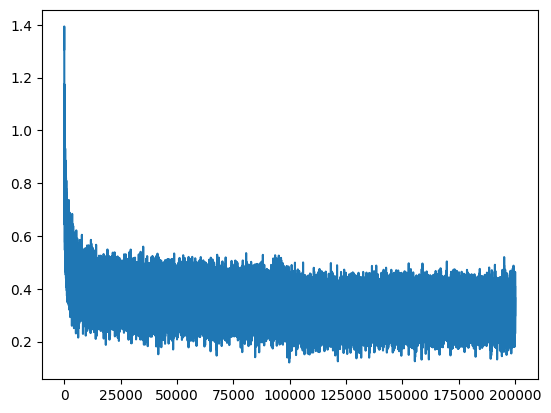

In [36]:
plt.plot(lossi)

In [37]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': [Xtr, Ytr],
        'dev' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 2.1144847869873047
dev 2.1695609092712402
test 2.161965847015381


In [38]:
# Sampling 

g = torch.Generator().manual_seed(SEED + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, 1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[c] for c in out))



mona.
mayah.
see.
mad.
ryla.
remmastendraeg.
adee.
daelin.
shy.
jenleigh.
van.
narahayzimilah.
cayshabergiaghies.
kinde.
jene.
jetton.
kuba.
ged.
ryyah.
fael.


### Fixing 